**ANALYZING SAARC CAPITAL STOCK DATA AND WORKING POPULATION FOR THEIR IMPACT ON GDP**

## Objective:
This analysis explores how private and public investment (P_stock & G_stock) interact with working population(work_popn), which are the factor of productions in standard Cobb-Douglas Equation, influence GDP. We use different models and compare their results.

- **Log-Linear Regression** for reflecting CoBB-Douglas Production Function.
- **Log-Linear Regression with Country and Decade Parameter** for time and country effect ( but not using Panel data analysis).
- **Random Forest Regression** for predictive modeling and  **SHAP values** to interpret feature importance.

## Key Research Questions:
1. Does **private investment** drive GDP more than **government investment**?
2. Do **public-private investments complement each other**, or substitute each other?

Dataset:SAARC economic indicators dataset from IMF CAPITALSTOCK DATATSET 2017 and WorldBank for Population Data. 
5 countries with highest ABSOLUTE GDP in SAARC Region for 46 years (1970 -2015)

In [109]:
# !pip install shap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# Load dataset
file_path = "SAARC_data.csv"
df= pd.read_csv(file_path)
df["work_popn"] = df["work_popn"]*2080/1000000000 #2080 working hour per year converted to billion-h
# Save DataFrame as a pickle file
df.to_pickle("saarc_data.pkl")

print (df.head())

      country  year  G_stock  P_stock  work_popn     GDP      popn
0  Bangladesh  1970   17.826   33.280  70.826939  91.131  65047770
1  Bangladesh  1971   18.570   34.603  72.002904  86.137  66424744
2  Bangladesh  1972   18.997   35.138  73.094382  74.101  67597470
3  Bangladesh  1973   18.895   34.393  74.216769  76.565  68691185
4  Bangladesh  1974   19.188   34.611  75.476213  83.909  69884420


In [3]:
# Load Dataframe from pickle file
# df_memory = pd.read_pickle("saarc_data.pkl")
# df =df_memory
# df["work_popn"] = df["work_popn"]*2080/1000000000 #2080 working hour per year converted to billion-h
# print (df.head())


**LOG TRANSFORMATION FOR COBB DOUGLAS PRODUCTION FUNCTION**

In [5]:
df_log = df.copy()
exclude_columns = ["country", "year", "popn"]
transform_columns = [column for column in df.columns if column not in exclude_columns]
df_log[transform_columns] = np.log(df_log[transform_columns])
print(df_log.head())
                                   

      country  year   G_stock   P_stock  work_popn       GDP      popn
0  Bangladesh  1970  2.880658  3.504957   4.260239  4.512298  65047770
1  Bangladesh  1971  2.921547  3.543940   4.276706  4.455939  66424744
2  Bangladesh  1972  2.944281  3.559283   4.291752  4.305429  67597470
3  Bangladesh  1973  2.938897  3.537853   4.306990  4.338140  68691185
4  Bangladesh  1974  2.954285  3.544172   4.323818  4.429733  69884420


In [6]:
features =df.columns[2:5]
X_log= df_log[features].values
y_log=df_log.iloc[:, -2].values

print("Class Distribution:\n", df_log.iloc[:, -2].value_counts())

Class Distribution:
 GDP
4.512298    1
4.983408    1
5.097681    1
5.144618    1
5.228040    1
           ..
8.138400    1
8.227188    1
8.315785    1
8.409287    1
5.452505    1
Name: count, Length: 230, dtype: int64


In [7]:
# Split dataset into training 80-20
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
#model = Linear
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [9]:
feature_names = list(df.drop(columns=['country', 'year','GDP', 'popn']).columns)
coefficients = model.coef_  
intercept = model.intercept_  

print("Intercept (a):", intercept)
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

linear_equation = f"Y = {intercept:.4f}"
for feature, coef in zip(feature_names, coefficients):
    linear_equation += f" + ({coef:.4f} * {feature})"

print("\nLinear Regression Equation:")
print(linear_equation)

Intercept (a): 5.32440292096979

Feature Coefficients:
G_stock: -0.0919
P_stock: 1.1792
work_popn: 0.5145

Linear Regression Equation:
Y = 5.3244 + (-0.0919 * G_stock) + (1.1792 * P_stock) + (0.5145 * work_popn)


In [10]:
# Convert intercept from log-scale
A = np.exp(intercept)  

# Print log-linear form
print("\nLog-Linear Model Equation:")
log_linear_equation = f"Y = {A:.4f}"
for feature, coef in zip(feature_names, coefficients):
    log_linear_equation += f" * {feature}^{coef:.4f}"

print(log_linear_equation)



Log-Linear Model Equation:
Y = 205.2858 * G_stock^-0.0919 * P_stock^1.1792 * work_popn^0.5145


In [11]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.1398
Root Mean Squared Error (RMSE): 0.1637
R-squared (R2 Score): 0.9879


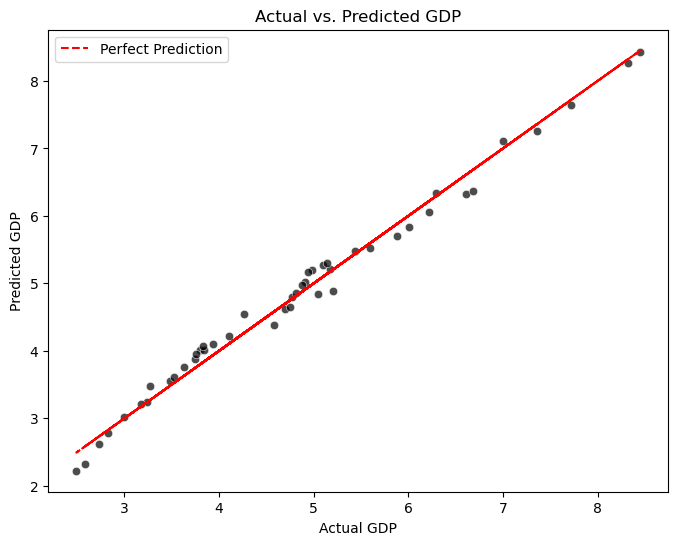

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()


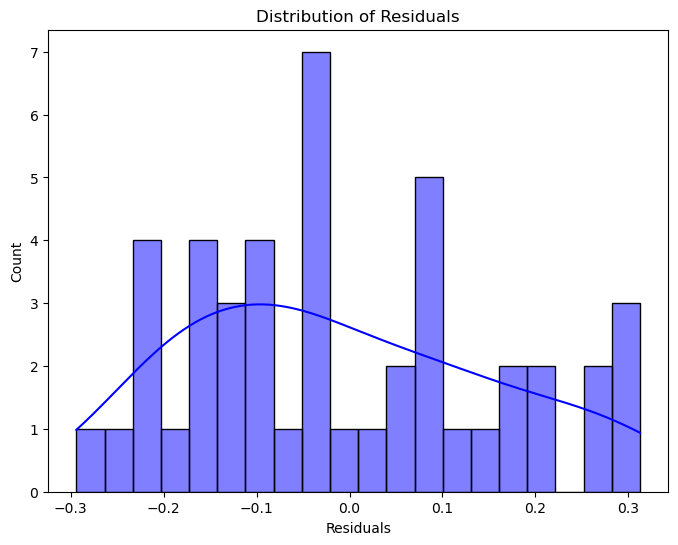

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


**LOG TRANSFORMED WITH BOTH COUNTRY AND TIME AS VARIABLES**

In [15]:
df_log_encoded = df_log.copy()

# One-hot encode 'country' 
df_log_encoded = pd.get_dummies(df_log_encoded, columns=['country'], drop_first=False)
df_log_encoded = df_log_encoded.drop(columns=['country_Nepal'])  # Nepal as the reference 

# Convert year into decades 
df_log_encoded['decade'] = (df_log_encoded['year'] // 10) * 10

df_log_encoded = pd.get_dummies(df_log_encoded, columns=['decade'], drop_first= False)

# Drop original 'year' column 
df_log_encoded = df_log_encoded.drop(columns=['year'])

# Define features and target variable
X_log = df_log_encoded.drop(columns=['GDP', 'popn'])  # Features
y_log = df_log_encoded['GDP']  # Target variable

# Display dataset 
print(X_log.head())


    G_stock   P_stock  work_popn  country_Bangladesh  country_India  \
0  2.880658  3.504957   4.260239                True          False   
1  2.921547  3.543940   4.276706                True          False   
2  2.944281  3.559283   4.291752                True          False   
3  2.938897  3.537853   4.306990                True          False   
4  2.954285  3.544172   4.323818                True          False   

   country_Pakistan  country_Sri Lanka  decade_1970  decade_1980  decade_1990  \
0             False              False         True        False        False   
1             False              False         True        False        False   
2             False              False         True        False        False   
3             False              False         True        False        False   
4             False              False         True        False        False   

   decade_2000  decade_2010  
0        False        False  
1        False        Fals

In [16]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardize numerical features 
numeric_cols = ["G_stock", "P_stock", "work_popn"] 
decade_cols = [col for col in X_log.columns if col.startswith("decade_")]
numeric_cols.extend(decade_cols)  

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict values on test data
y_pred = model.predict(X_test)

In [18]:

feature_names = list(df_log_encoded.drop(columns=['GDP', 'popn']).columns)  
coefficients = model.coef_
intercept = model.intercept_

print("Intercept (a):", intercept)
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, coefficients): 
    print(f"{feature}: {coef:.4f}")

# Construct the linear regression equation
linear_equation = f"Y = {intercept:.4f}"
for feature, coef in zip(feature_names, coefficients):  
    linear_equation += f" + ({coef:.4f} * {feature})"

print("\nLinear Regression Equation:")
print(linear_equation)


Intercept (a): 4.729666479934439

Feature Coefficients:
G_stock: 0.0101
P_stock: 0.3242
work_popn: 0.9399
country_Bangladesh: 0.4072
country_India: 0.8829
country_Pakistan: 0.9106
country_Sri Lanka: 0.6937
decade_1970: -0.1565
decade_1980: -0.0858
decade_1990: 0.0058
decade_2000: 0.0935
decade_2010: 0.1695

Linear Regression Equation:
Y = 4.7297 + (0.0101 * G_stock) + (0.3242 * P_stock) + (0.9399 * work_popn) + (0.4072 * country_Bangladesh) + (0.8829 * country_India) + (0.9106 * country_Pakistan) + (0.6937 * country_Sri Lanka) + (-0.1565 * decade_1970) + (-0.0858 * decade_1980) + (0.0058 * decade_1990) + (0.0935 * decade_2000) + (0.1695 * decade_2010)


In [19]:
# Compute the transformed intercept (A = e^intercept)
A = np.exp(intercept)

# Construct the log-linear equation
log_linear_equation = f"Y = {A:.4f}"

for feature, coef in zip(feature_names, coefficients):
    if "country" in feature or "decade" in feature:
        # Exponential transformation for categorical variables
        log_linear_equation += f" * e^({coef:.4f} * {feature})"
    else:
        # Power transformation for continuous variables
        log_linear_equation += f" * {feature}^{coef:.4f}"

print("\nLog-Linear Model Equation:")
print(log_linear_equation)


Log-Linear Model Equation:
Y = 113.2578 * G_stock^0.0101 * P_stock^0.3242 * work_popn^0.9399 * e^(0.4072 * country_Bangladesh) * e^(0.8829 * country_India) * e^(0.9106 * country_Pakistan) * e^(0.6937 * country_Sri Lanka) * e^(-0.1565 * decade_1970) * e^(-0.0858 * decade_1980) * e^(0.0058 * decade_1990) * e^(0.0935 * decade_2000) * e^(0.1695 * decade_2010)


In [20]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.0912
Root Mean Squared Error (RMSE): 0.1125
R-squared (R2 Score): 0.9943


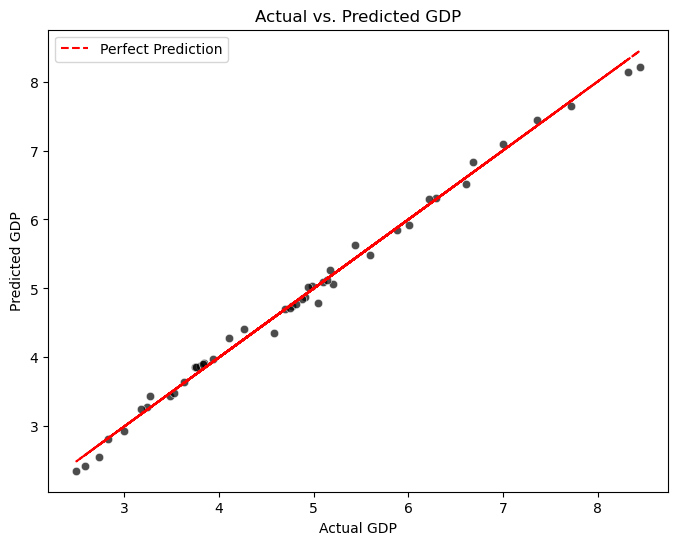

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()

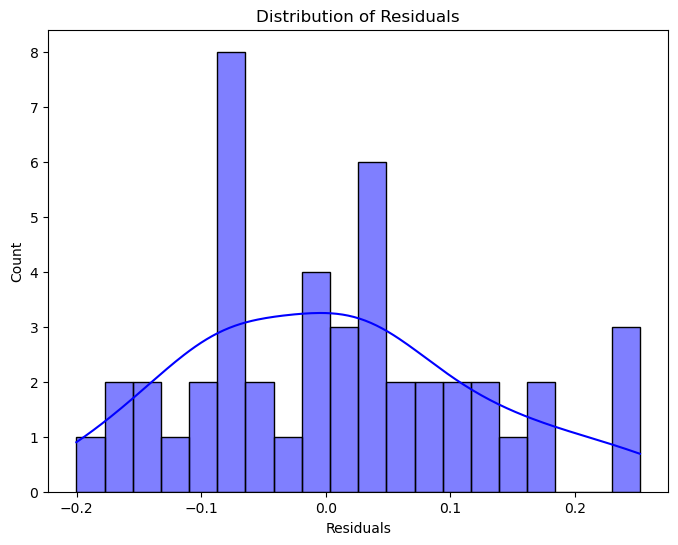

In [22]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


**RANDOM FOREST**

In [24]:
df_rf = df.copy()

log_features = ["G_stock", "P_stock", "work_popn", "GDP"]
for col in log_features:
    df_rf[col] = np.log(df_rf[col] + 0.00001) 
    
# One-hot encode 'country'
df_rf = pd.get_dummies(df_rf, columns=['country'], drop_first=False)

# Convert 'year' into decades
df_rf['decade'] = (df_rf['year'] // 10) * 10

# Drop original 'year' column 
df_rf = df_rf.drop(columns=['year'])

# One-hot encode 'decade'
df_rf = pd.get_dummies(df_rf, columns=['decade'], drop_first=False)

# Define features and target variable
X_rf = df_rf.drop(columns=['GDP', 'popn'])  # Features
y_rf = df_rf['GDP']  # Target variable 

# Display dataset 
print(X_rf.head())


    G_stock   P_stock  work_popn  country_Bangladesh  country_India  \
0  2.880659  3.504957   4.260240                True          False   
1  2.921548  3.543941   4.276707                True          False   
2  2.944282  3.559283   4.291752                True          False   
3  2.938898  3.537853   4.306990                True          False   
4  2.954286  3.544172   4.323818                True          False   

   country_Nepal  country_Pakistan  country_Sri Lanka  decade_1970  \
0          False             False              False         True   
1          False             False              False         True   
2          False             False              False         True   
3          False             False              False         True   
4          False             False              False         True   

   decade_1980  decade_1990  decade_2000  decade_2010  
0        False        False        False        False  
1        False        False        False

In [25]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)


In [26]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=500,max_depth =10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict values on test data
y_pred = rf_model.predict(X_test)

In [27]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.0340
Root Mean Squared Error (RMSE): 0.0618
R-squared (R2 Score): 0.9983


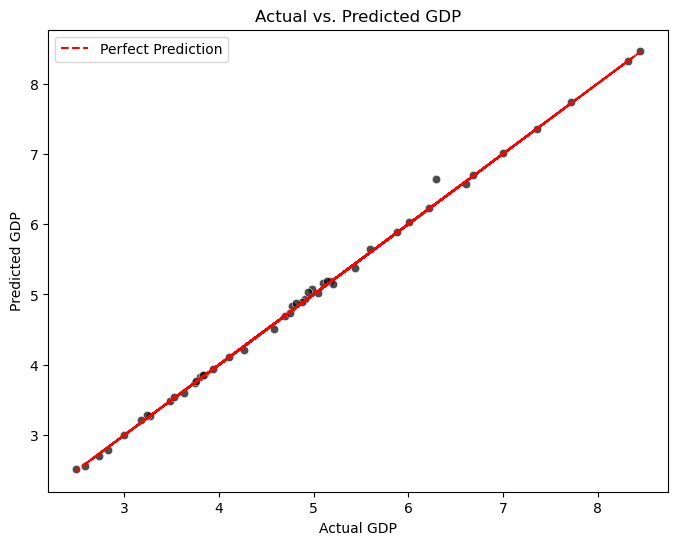

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()

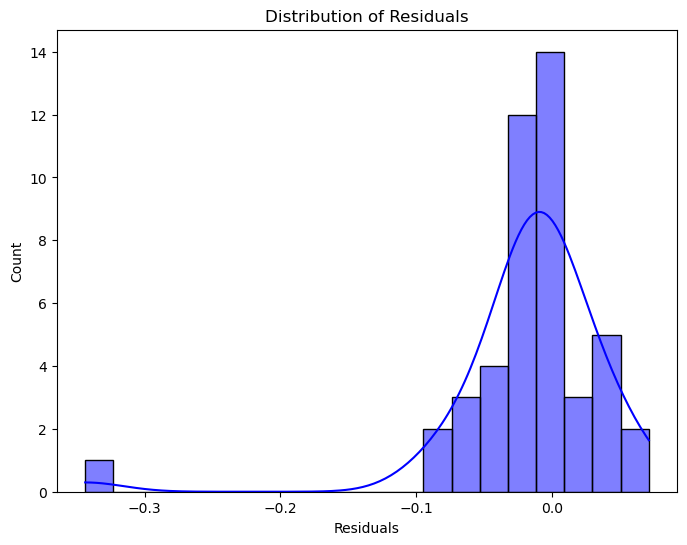

In [29]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


In [30]:
# Extract feature importance 
feature_importances = rf_model.feature_importances_

# Normalize importance
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame 
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Approx. Coefficient)': feature_importances_normalized
}).sort_values(by='Importance (Approx. Coefficient)', ascending=False)

# Display the DataFrame 
coefficients_df['Importance (Approx. Coefficient)'] = coefficients_df['Importance (Approx. Coefficient)'].apply(lambda x: f"{x:.6f}")
print("\nRandom Forest Approximate Coefficients:")
print(coefficients_df.to_string(index=False))



Random Forest Approximate Coefficients:
           Feature Importance (Approx. Coefficient)
           P_stock                         0.614765
           G_stock                         0.287019
         work_popn                         0.092663
     country_Nepal                         0.003255
       decade_2010                         0.000573
       decade_1980                         0.000336
       decade_1970                         0.000315
country_Bangladesh                         0.000304
       decade_2000                         0.000284
       decade_1990                         0.000218
 country_Sri Lanka                         0.000201
  country_Pakistan                         0.000065
     country_India                         0.000002


C:\Users\Sushil\AppData\Local\Temp\ipykernel_47528\3779739863.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_series, y=feature_importances_series.index, palette="viridis")


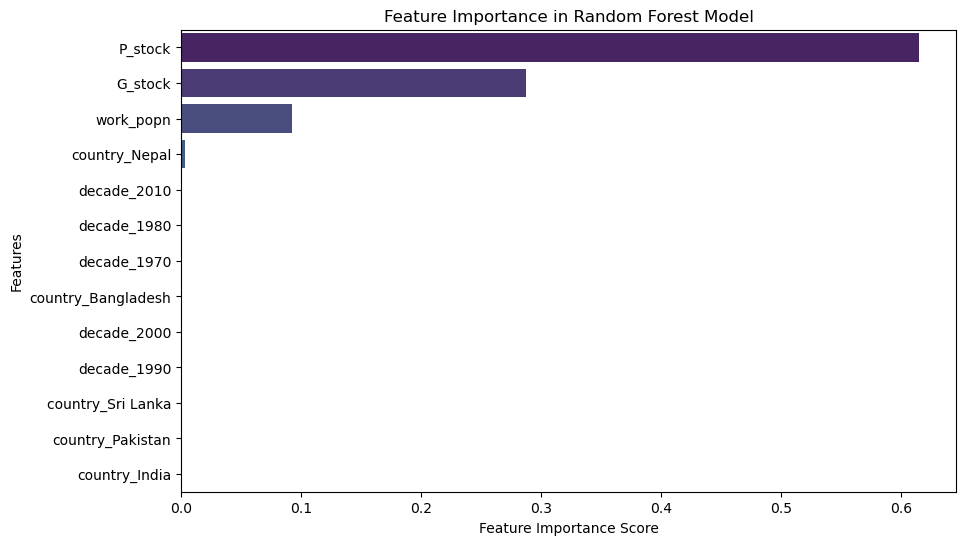

In [31]:
feature_importances_series = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

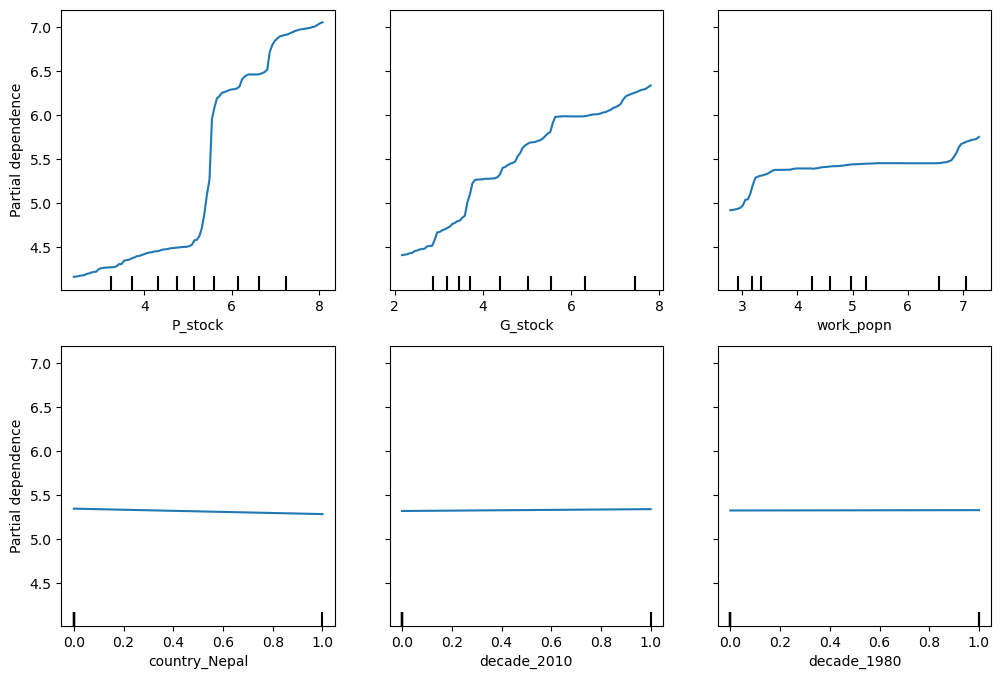

In [32]:
# Select top features for PDP visualization
top_features = coefficients_df['Feature'].head(6).tolist()

# Plot Partial Dependence Plots (PDPs) 
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=top_features, ax=ax)
plt.show()


In [33]:
# Convert all columns in X_train to numeric 
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

print("Non-numeric columns:", X_train.select_dtypes(include=['O']).columns.tolist())


Non-numeric columns: []


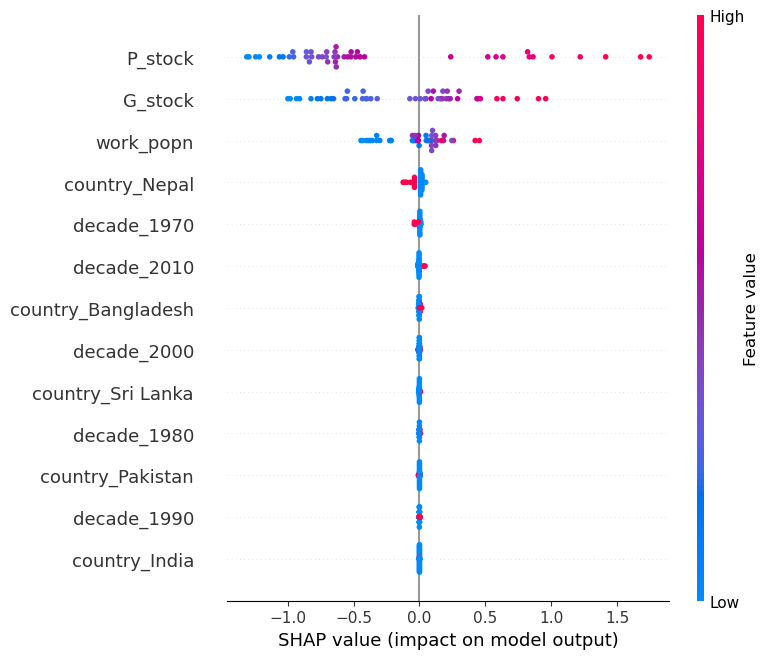

In [34]:
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP values
shap.summary_plot(shap_values, X_test)



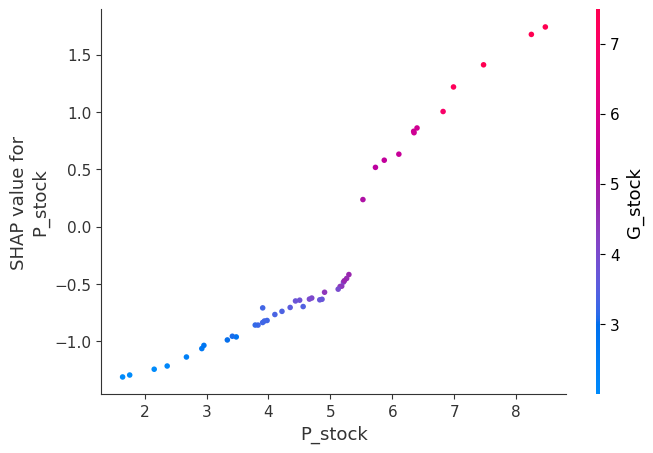

In [35]:
# SHAP dependence plot for interaction between P_stock and G_stock
shap.dependence_plot("P_stock", shap_values, X_test, interaction_index="G_stock")


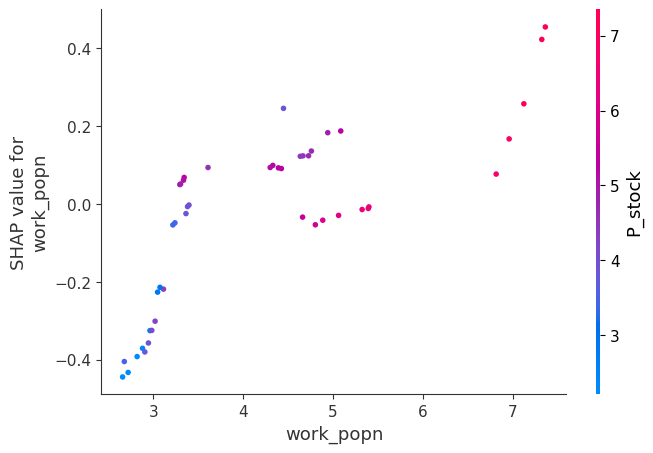

In [36]:
# SHAP dependence plot for interaction between work_popn and P_stock
shap.dependence_plot("work_popn", shap_values, X_test, interaction_index="P_stock")

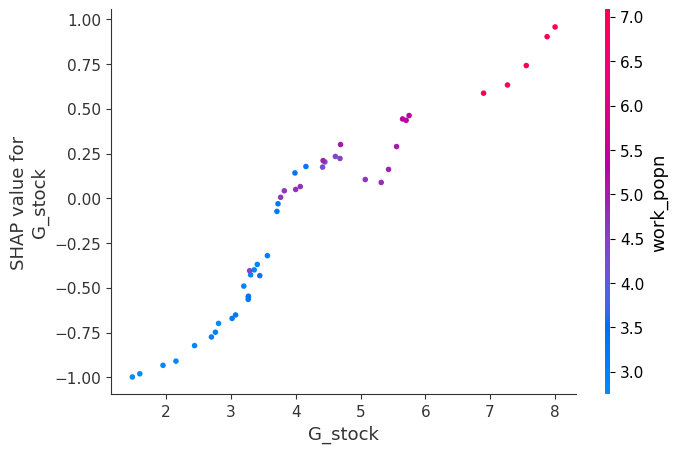

In [37]:
# SHAP dependence plot for interaction between G_stock and work_popn
shap.dependence_plot("G_stock", shap_values, X_test, interaction_index="work_popn")

*From this analysis, we found that the private capital stock is the most important determinant for GDP followed by Government Capital stock, which compliments the earlier shown by significant changes in SHAP Values when Private stock is greater than 5 and closely followed by Government stock.*

*Among the models, Random Forest has the best Rsquare value as well we can see the residuals are near to normal distribution. Also All three factors of productions has significant values only in this model*